### This notebook is helpful for visualizing and/or debugging system performance such as: battery dispatch, and cambium price signals. It produces an hourly facet grid. 

In [1]:
import pickle
import os
os.chdir(os.pardir)
from vapor.models import WindMerchantPlant, PVMerchantPlant, Cambium, BuildingLoad
from vapor import datafetcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# --- colors for plots ---
nrel_color_dict = [
                '#0077C8', #darkblue
                '#00A9E0', #lightblue
                '#658D1B', #darkgreen
                '#84BD00', #lightgreen
                '#FFC72C', #yellow
                '#DE7C00', #orange
                '#5B6770', #darkgray
                '#C1C6C8'#lightgray
                ] 

tech_dict = {
    'pv':nrel_color_dict[4],
    'wind':nrel_color_dict[1],
    'batt':nrel_color_dict[3]
    }

2021-02-04 15:21:40,003 [MainThread  ] [INFO ]  Starting log for vapor...


## Set Up

In [2]:
region = 'p61' #west texas
aggregate_region = 'pca'

# --- Get lookup of centroids ---
CentroidsLookup = datafetcher.GetCentroidOfRegions(aggregate_region=aggregate_region)
CentroidsLookup.find_centroids()
centroids_dict = CentroidsLookup.centroids_lookup #keys=region, values=lat/lon centorid tuple

# --- fetch resource data for lat/lon tuples ---
pv_fetcher = datafetcher.FetchResourceFiles(tech='pv')
pv_fetcher.fetch(centroids_dict.values())
wind_fetcher = datafetcher.FetchResourceFiles(tech='wind')
wind_fetcher.fetch(centroids_dict.values()) 

# --- convert tuples dict to aggregate region dict ---
pv_tuple_dict = pv_fetcher.resource_file_paths_dict #keys=lat/lon, values=centroid resource file path    
pv_resource_file_dict = {k:pv_tuple_dict[v] for k,v in centroids_dict.items()} #keys=region, value=resource file path
pv_resource_file = pv_resource_file_dict[region]
wind_tuple_dict = wind_fetcher.resource_file_paths_dict #keys=lat/lon, values=centroid resource file path    
wind_resource_file_dict = {k:wind_tuple_dict[v] for k,v in centroids_dict.items()} #keys=region, value=resource file path
wind_resource_file = wind_resource_file_dict[region]

# --- load cambium ---
cambium_df = datafetcher.load_cambium_data(aggregate_region=aggregate_region, scenario='StdScen20_MidCase')
cambium = Cambium(cambium_df, aggregate_region, region, pv_resource_file)
cambium.clean()

2021-02-04 15:21:59,202 [MainThread  ] [INFO ]  Beginning data download for pv using 8 thread workers
2021-02-04 15:21:59,226 [MainThread  ] [INFO ]  ....finished data download
2021-02-04 15:21:59,227 [MainThread  ] [INFO ]  Beginning data download for wind using 8 thread workers
2021-02-04 15:21:59,249 [MainThread  ] [INFO ]  ....finished data download
2021-02-04 15:21:59,250 [MainThread  ] [INFO ]  

2021-02-04 15:21:59,251 [MainThread  ] [INFO ]  Loading cambium data from pickle


In [3]:
# --- Run PV System with Battery ---

pv_system_config = {
    
    'SystemDesign': {
        'dc_ac_ratio': 1.2,
        'subarray1_azimuth': 180.0,
        'subarray1_tilt': 0, 
        'subarray1_track_mode': 1, 
        'system_capacity': 100000, #desired RE kw
        'subarray1_backtrack': 0, 
        'subarray1_nstrings': 26881, 
        'inverter_count': 1388
    }, 
    
    'BatteryTools': {
        'desired_power': 25000.0, #desired batt kw
        'desired_capacity': 4, #desired batt hrs
        'desired_voltage': 500
    },
    
    'BatterySystem': {
        'en_batt': 1, 
        'batt_meter_position': 0
    }
}

pv_model = PVMerchantPlant(pv_system_config, pv_resource_file, cambium, region)
pv_model.execute_all()


In [4]:
# --- Run PV System with no Battery ---

pv_nb_system_config = {
    
    'SystemDesign': {
        'dc_ac_ratio': 1.2,
        'subarray1_azimuth': 180.0,
        'subarray1_tilt': 0, 
        'subarray1_track_mode': 1, 
        'system_capacity': 100000, #desired RE kw
        'subarray1_backtrack': 0, 
        'subarray1_nstrings': 26881, 
        'inverter_count': 1388
    }, 
    
    'BatteryTools': {
        'desired_power': 0.0, #desired batt kw
        'desired_capacity': 4, #desired batt hrs
        'desired_voltage': 500
    },
    
    'BatterySystem': {
        'en_batt': 0, 
        'batt_meter_position': 0
    }
}

pv_nb_model = PVMerchantPlant(pv_nb_system_config, pv_resource_file, cambium, region)
pv_nb_model.execute_all()

In [5]:
# --- Run Wind System with Battery ---

wind_system_config = {
    
    'Turbine': {
        'wind_turbine_hub_ht': 80, 
        'turbine_class':7
    }, 
    
    'Farm': {
        'system_capacity': 100000 #desired RE kw
    },
    
    'Resource': {
        'wind_resource_model_choice': 0
    }, 
    
    'BatteryTools': {
        'desired_power': 25000.0, #desired batt kw
        'desired_capacity': 4, #desired batt hrs
        'desired_voltage': 500
    },
    
    'BatterySystem': {
        'en_batt': 1, 
        'batt_meter_position': 0
    },
}

wind_model = WindMerchantPlant(wind_system_config, wind_resource_file, cambium, region)
wind_model.execute_all()

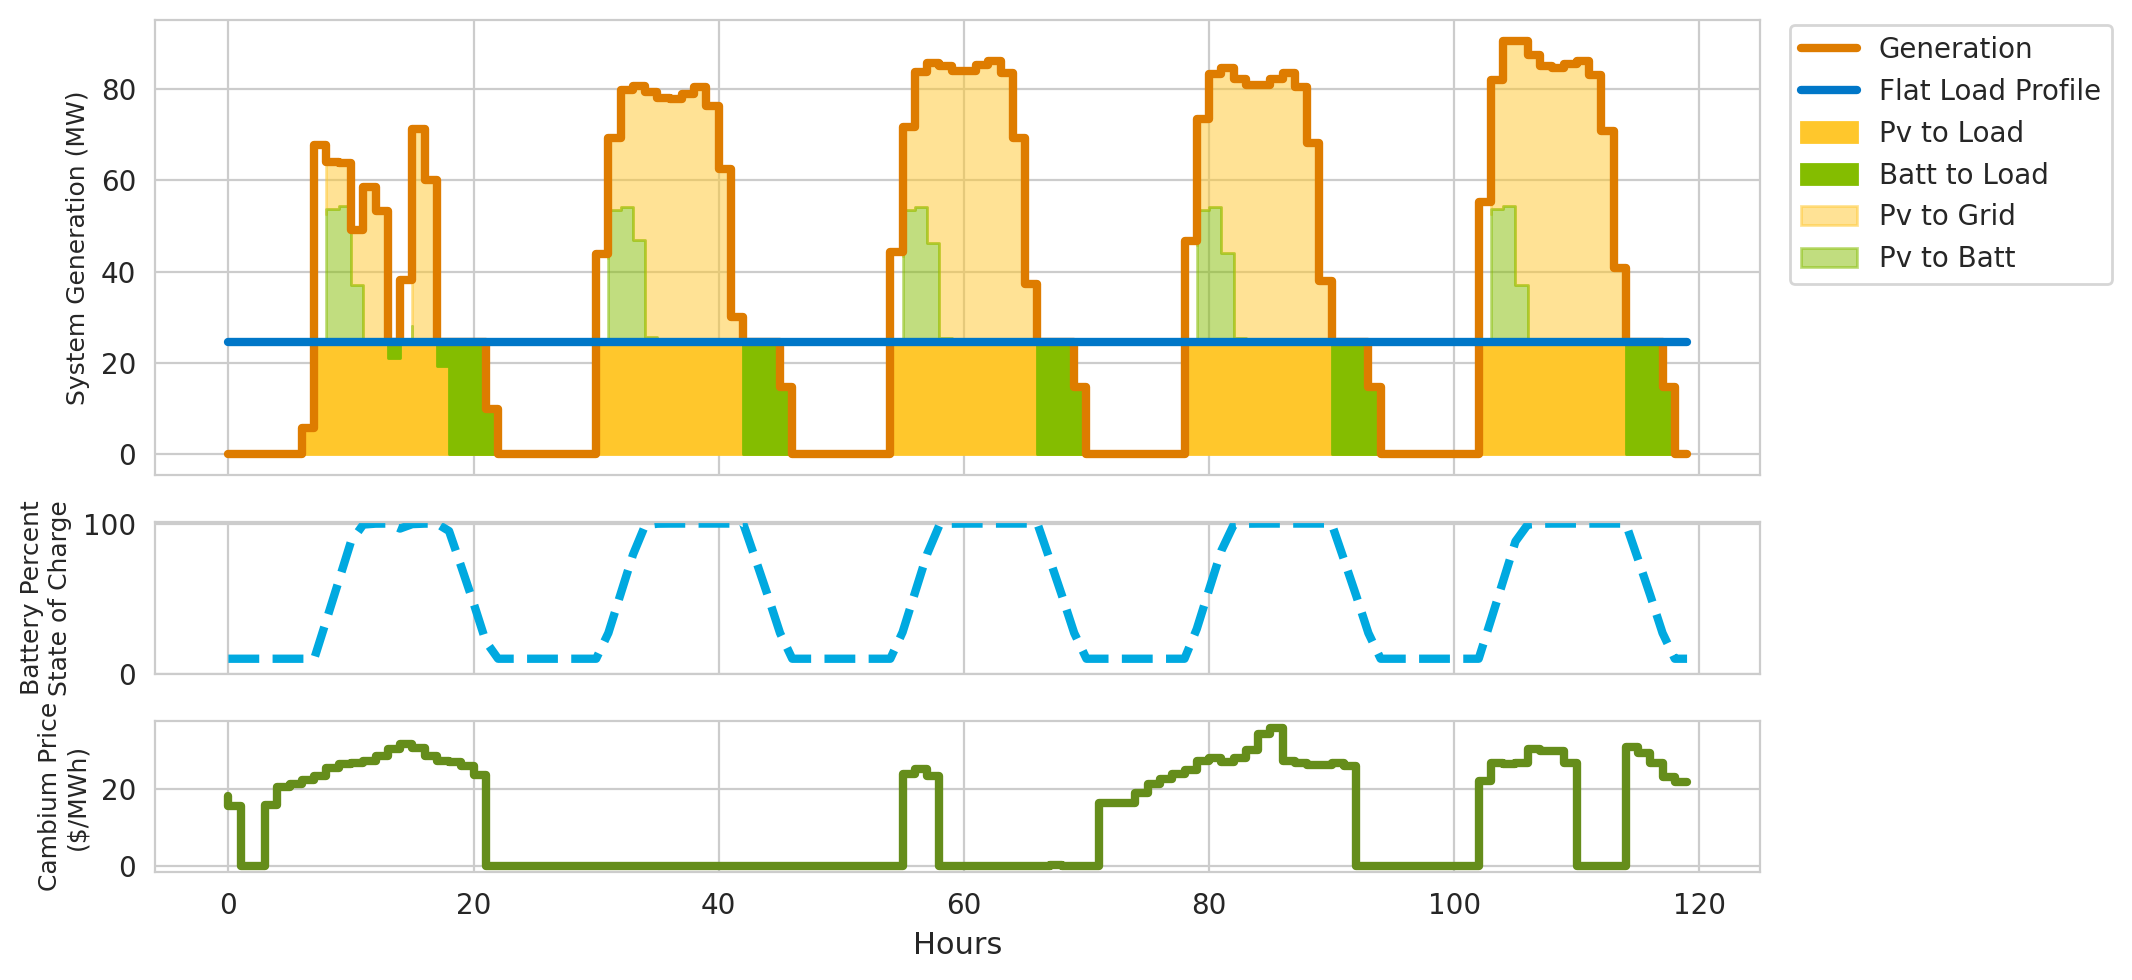

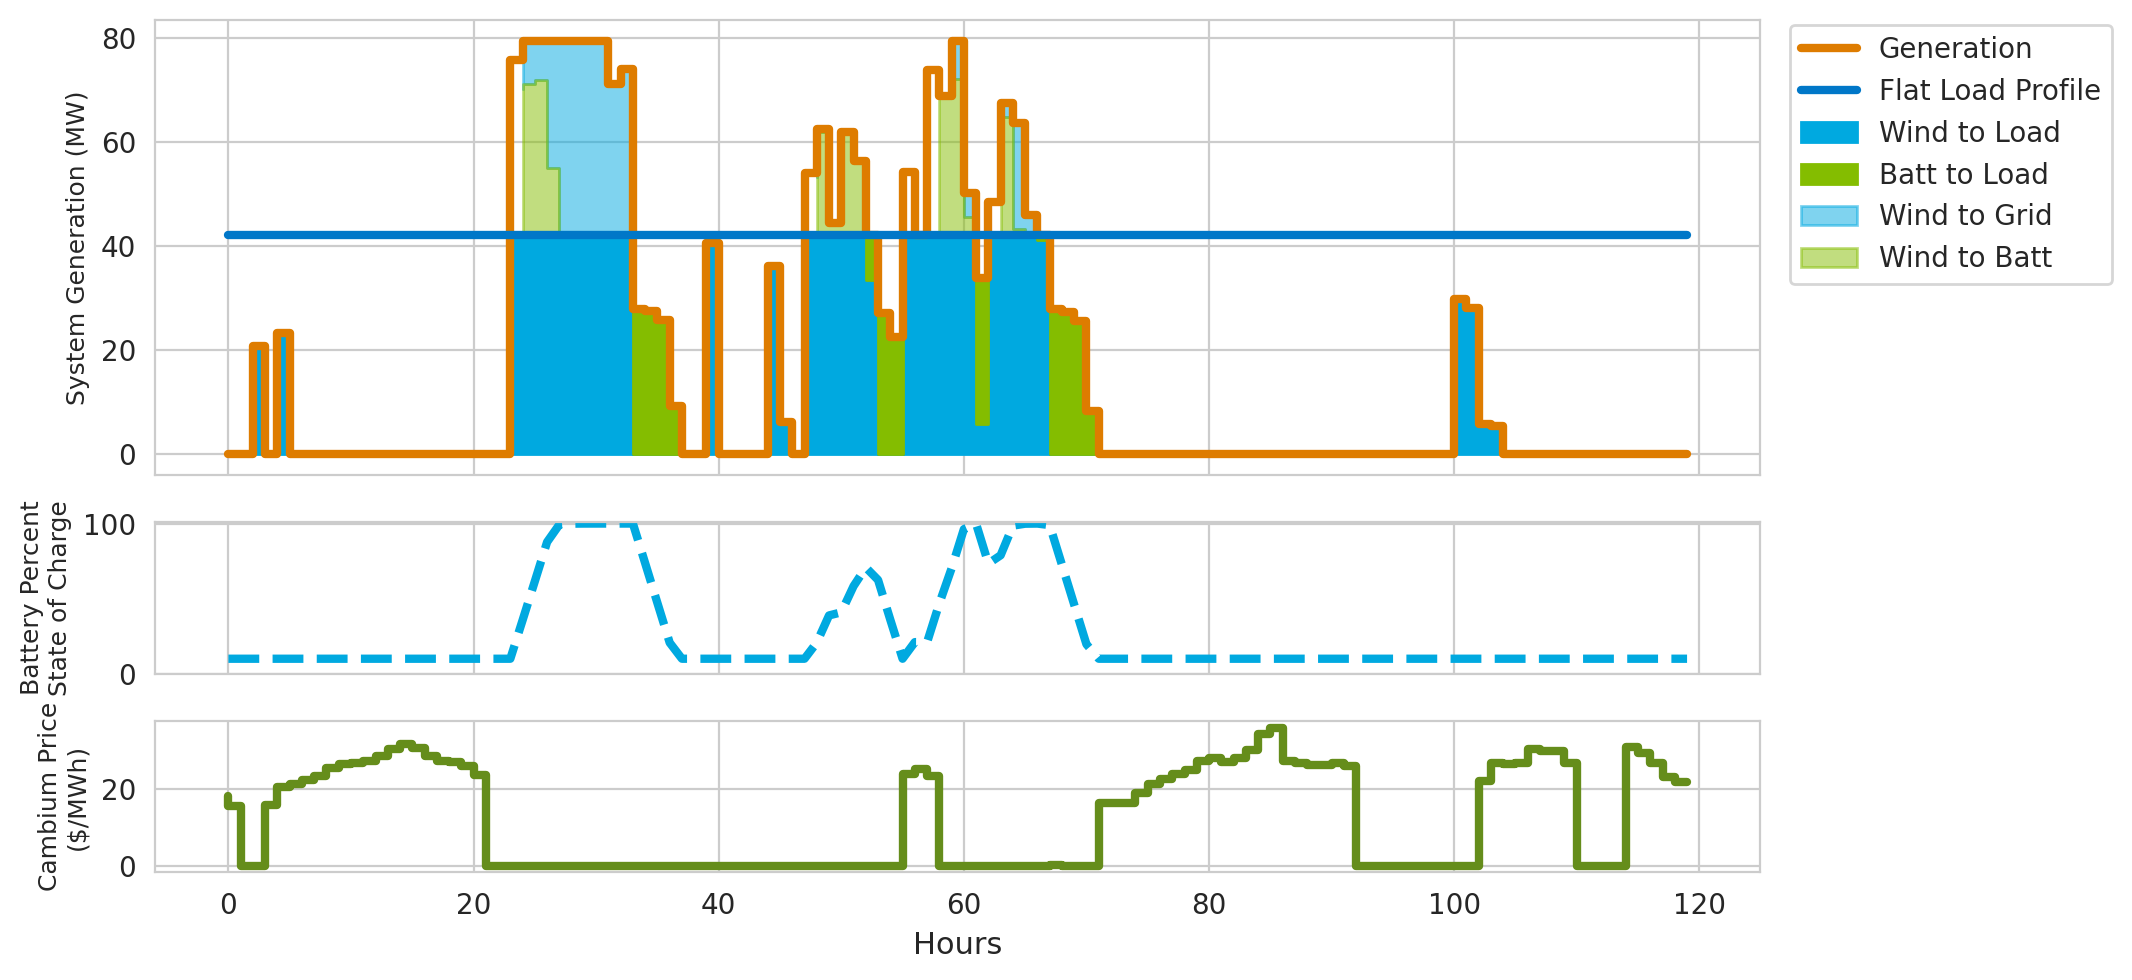

In [13]:
# --- Define function to plot generation ---

def plot_gen(model, tech):
    assert tech in ['pv', 'wind']
    
    sns.set_style('whitegrid')

    batt_ts = pd.DataFrame({
        'load':model.load.as_array(),
        'batt_to_load':model.battery.Outputs.batt_to_load[0:8760],
        f'{tech}_to_batt':model.battery.Outputs.pv_to_batt[0:8760],
        f'{tech}_to_grid':model.battery.Outputs.pv_to_grid[0:8760],
        f'{tech}_to_load':model.battery.Outputs.pv_to_load[0:8760],
        'gen':model.generator.Outputs.gen[0:8760],
        'soc':model.battery.Outputs.batt_SOC[0:8760],
        'market_profile':[i[1] for i in model.market_profile[0:8760]]
    })
    batt_ts[['load','batt_to_load',f'{tech}_to_batt', f'{tech}_to_grid',f'{tech}_to_load','gen']] /= 1e3
    batt_ts['self_consume'] = batt_ts['batt_to_load'] + batt_ts[f'{tech}_to_load']
    batt_ts['total_gen'] = batt_ts['self_consume'] + batt_ts[f'{tech}_to_grid'] + batt_ts[f'{tech}_to_batt']

    batt_ts = batt_ts[(30*24*3):(30*24*3)+(24*5)]
    batt_ts.reset_index(inplace=True)

    fig = plt.figure(figsize=(9,5), dpi=200)
    gs = gridspec.GridSpec(3,1, height_ratios=[3,1,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])

    x = batt_ts.index
    zeros = np.zeros_like(x)


    gen = ax1.step(x, batt_ts['total_gen'], label='Generation', linewidth=3, where='pre', color=nrel_color_dict[5])
    load = ax1.plot(batt_ts['load'], label='Flat Load Profile', linewidth=3, color=nrel_color_dict[0])

    ax1.fill_between(x, zeros, batt_ts[f'{tech}_to_load'],
                     label=f'{tech.capitalize()} to Load', step='pre',
                     color=tech_dict[tech])

    ax1.fill_between(x, batt_ts[f'{tech}_to_load'], batt_ts['self_consume'],
                     label='Batt to Load', step='pre',
                     color=nrel_color_dict[3])

    ax1.fill_between(x, batt_ts['load']+batt_ts[f'{tech}_to_batt'], batt_ts['total_gen'],
                     where=(batt_ts['total_gen'] > batt_ts['load']+batt_ts[f'{tech}_to_batt']), 
                     label=f'{tech.capitalize()} to Grid', step='pre',
                     color=tech_dict[tech], alpha=0.5)

    ax1.fill_between(x, batt_ts['load'], batt_ts['load']+batt_ts[f'{tech}_to_batt'],
                     where=batt_ts['total_gen'] >= batt_ts['load'],
                     label=f'{tech.capitalize()} to Batt', step='pre',
                     color=nrel_color_dict[3], alpha=0.5)

    ax1.set_ylabel('System Generation (MW)', size=9)


    ax2.plot(batt_ts['soc'], linestyle='--', linewidth=3, color=nrel_color_dict[1])
    ax2.set_ylim(0,101)
    ax2.set_ylabel('Battery Percent\nState of Charge', size=9)

    ax3.step(x, batt_ts['market_profile'], linewidth=3, where='pre', color=nrel_color_dict[2])
    ax3.set_ylabel('Cambium Price\n($/MWh)', size=9)
    ax3.set_xlabel('Hours', size=11)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    fig.tight_layout()

    ax1.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')
    
plot_gen(pv_model, 'pv')
plot_gen(wind_model, 'wind')

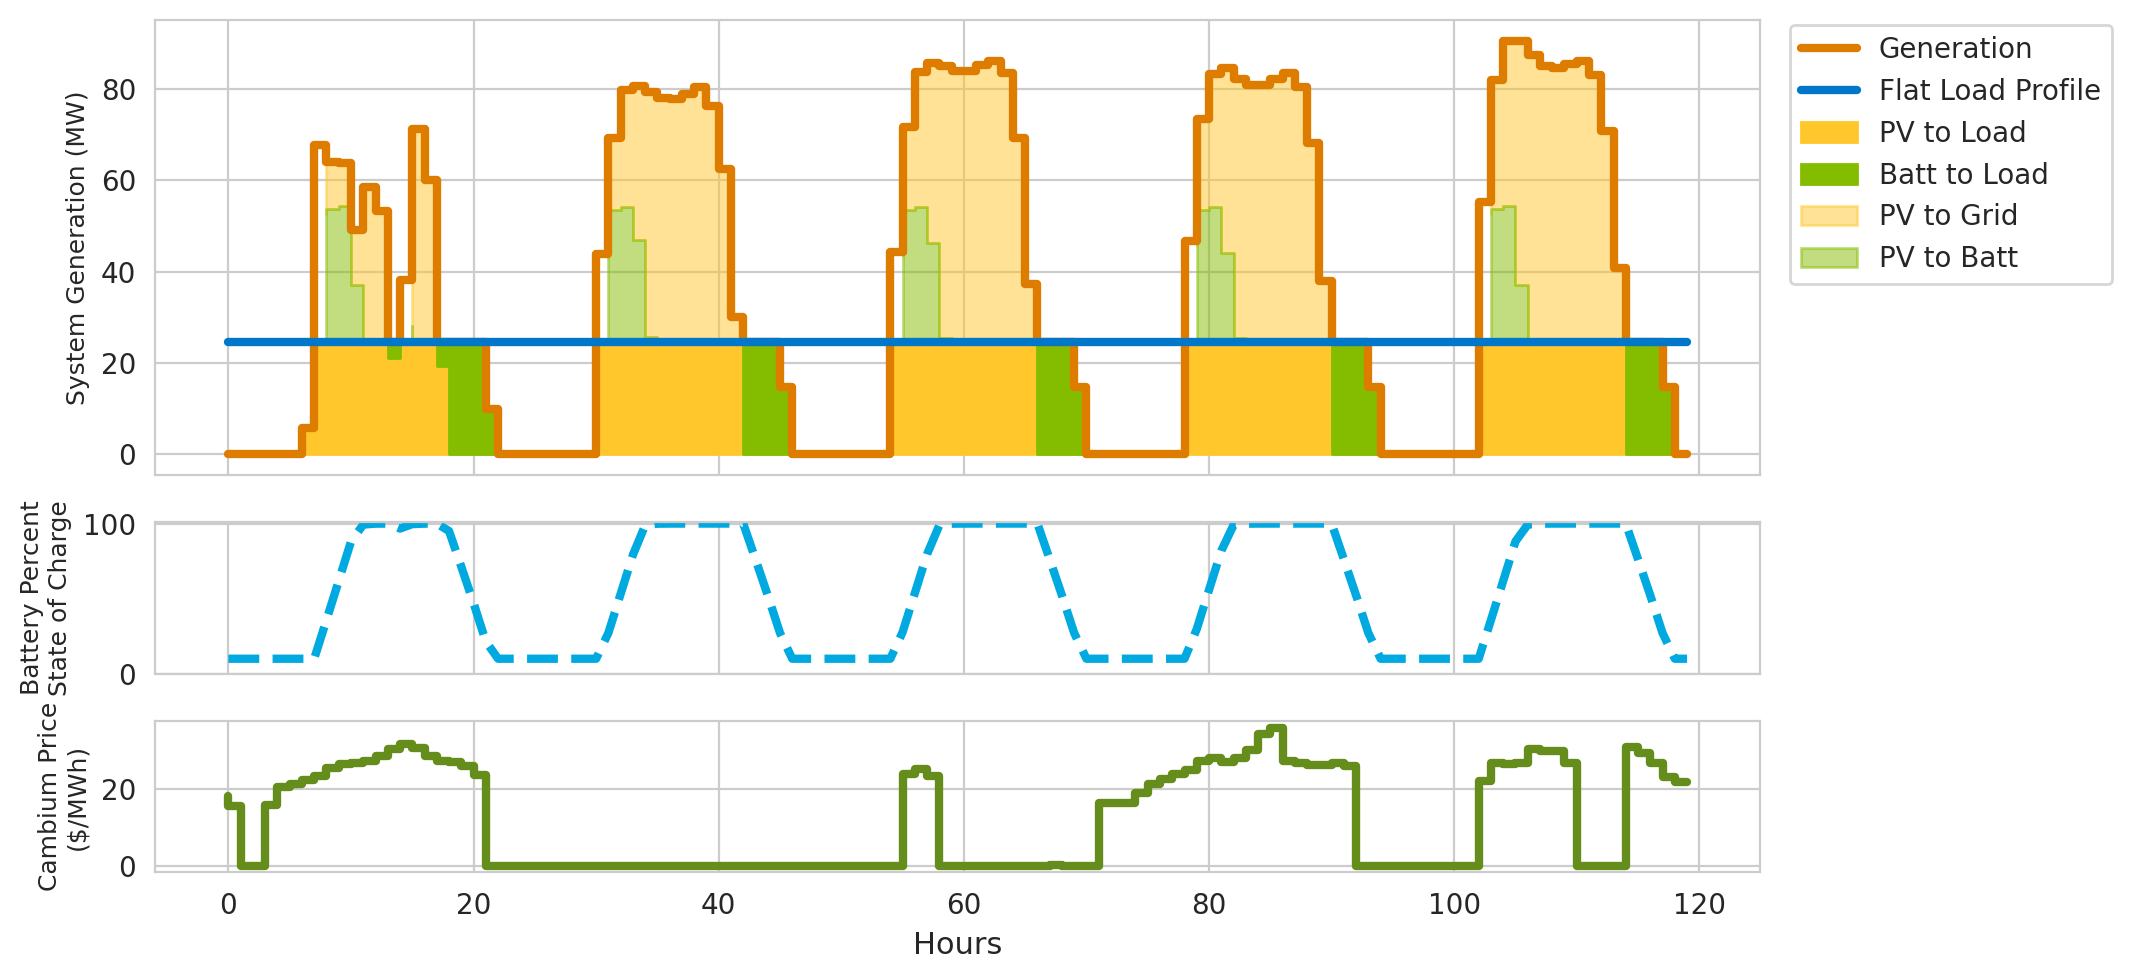

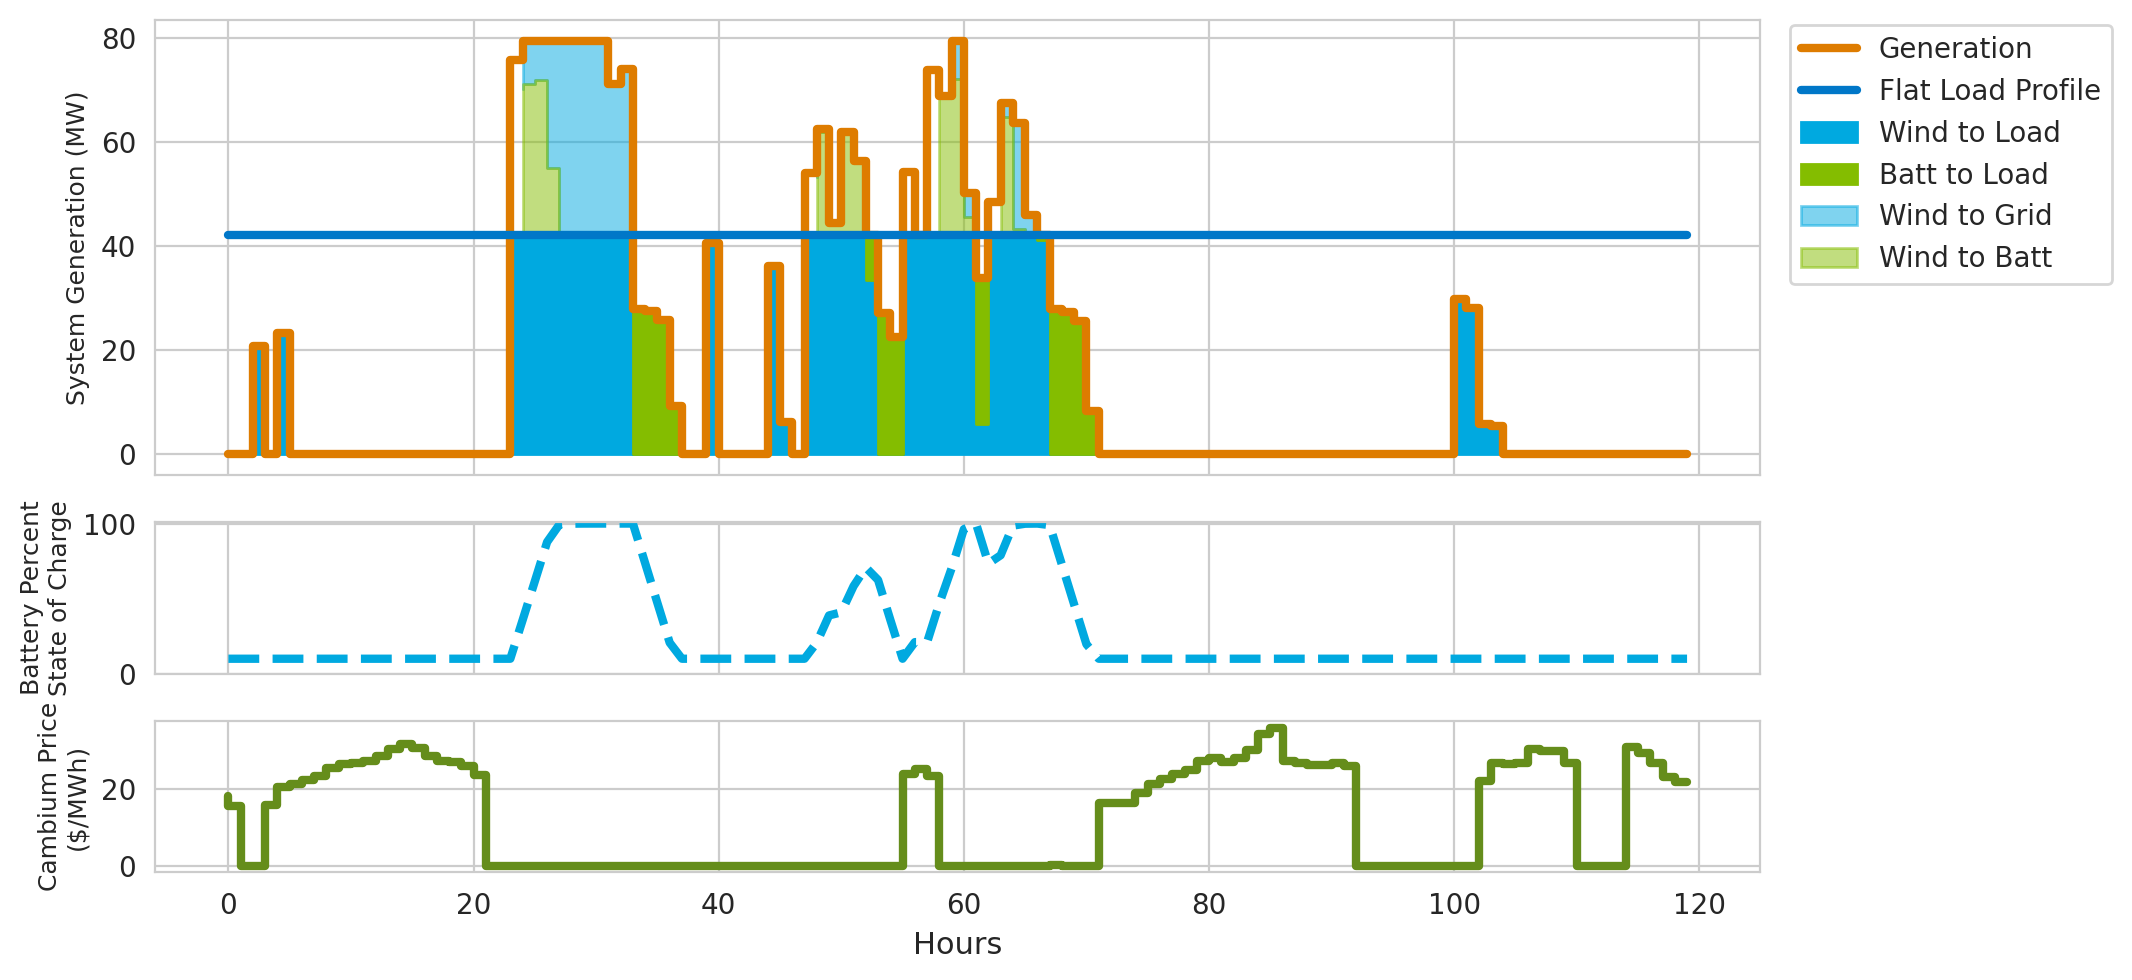

In [6]:
# --- Define function to plot generation ---

def plot_gen(model, tech):
    assert tech in ['pv', 'wind']
    
    sns.set_style('whitegrid')

    batt_ts = pd.DataFrame({
        'load':model.load.as_array(),
        'batt_to_load':model.battery.Outputs.batt_to_load[0:8760],
        f'{tech}_to_batt':model.battery.Outputs.pv_to_batt[0:8760],
        f'{tech}_to_grid':model.battery.Outputs.pv_to_grid[0:8760],
        f'{tech}_to_load':model.battery.Outputs.pv_to_load[0:8760],
        'gen':model.generator.Outputs.gen[0:8760],
        'soc':model.battery.Outputs.batt_SOC[0:8760],
        'market_profile':[i[1] for i in model.market_profile[0:8760]]
    })
    batt_ts[['load','batt_to_load',f'{tech}_to_batt', f'{tech}_to_grid',f'{tech}_to_load','gen']] /= 1e3
    batt_ts['self_consume'] = batt_ts['batt_to_load'] + batt_ts[f'{tech}_to_load']
    batt_ts['total_gen'] = batt_ts['self_consume'] + batt_ts[f'{tech}_to_grid'] + batt_ts[f'{tech}_to_batt']

    batt_ts = batt_ts[(30*24*3):(30*24*3)+(24*5)]
    batt_ts.reset_index(inplace=True)

    fig = plt.figure(figsize=(9,5), dpi=200)
    gs = gridspec.GridSpec(3,1, height_ratios=[3,1,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])

    x = batt_ts.index
    zeros = np.zeros_like(x)

    if tech == 'pv':
        tech_label = "PV"
    else:
        tech_label = tech.capitalize()

    gen = ax1.step(x, batt_ts['total_gen'], label='Generation', linewidth=3, where='pre', color=nrel_color_dict[5])
    load = ax1.plot(batt_ts['load'], label='Flat Load Profile', linewidth=3, color=nrel_color_dict[0])

    ax1.fill_between(x, zeros, batt_ts[f'{tech}_to_load'],
                     label=f'{tech_label} to Load', step='pre',
                     color=tech_dict[tech])

    ax1.fill_between(x, batt_ts[f'{tech}_to_load'], batt_ts['self_consume'],
                     label='Batt to Load', step='pre',
                     color=nrel_color_dict[3])

    ax1.fill_between(x, batt_ts['load']+batt_ts[f'{tech}_to_batt'], batt_ts['total_gen'],
                     where=(batt_ts['total_gen'] > batt_ts['load']+batt_ts[f'{tech}_to_batt']), 
                     label=f'{tech_label} to Grid', step='pre',
                     color=tech_dict[tech], alpha=0.5)

    ax1.fill_between(x, batt_ts['load'], batt_ts['load']+batt_ts[f'{tech}_to_batt'],
                     where=batt_ts['total_gen'] >= batt_ts['load'],
                     label=f'{tech_label} to Batt', step='pre',
                     color=nrel_color_dict[3], alpha=0.5)

    ax1.set_ylabel('System Generation (MW)', size=9)


    ax2.plot(batt_ts['soc'], linestyle='--', linewidth=3, color=nrel_color_dict[1])
    ax2.set_ylim(0,101)
    ax2.set_ylabel('Battery Percent\nState of Charge', size=9)

    ax3.step(x, batt_ts['market_profile'], linewidth=3, where='pre', color=nrel_color_dict[2])
    ax3.set_ylabel('Cambium Price\n($/MWh)', size=9)
    ax3.set_xlabel('Hours', size=11)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    fig.tight_layout()

    ax1.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')

plot_gen(pv_model, 'pv')
plot_gen(wind_model, 'wind')

In [30]:
def print_pv_outputs(model):

    if hasattr(model, 'battery'):
        print('gen to load')
        print(np.array(model.generator.Outputs.pv_to_load)[48:72].sum())
        print('')

        print('gen to grid')
        print(np.array(model.generator.Outputs.pv_to_grid)[48:72].sum())
        print('')

    
        print('batt to load')
        print(np.array(model.generator.Outputs.batt_to_load)[48:72].sum())
        print('')

    print('total')
    print(model.outputs['lifetime_gen_profile'][48:72].sum())

print_pv_outputs(pv_model)
print_pv_outputs(pv_nb_model)

gen to load
233533.79990358223

gen to grid
141589.20565336058

batt to load
90476.30206807874

total
465599.30762502155
total
476769.9688602932
